# Heart Rate Forecasting from Patient Sensor Data

Monitoring heart rate fluctuations is essential for early cardiac event detection. This notebook develops a time series model to forecast the next 20 minutes of "Lifetouch Heart Rate" readings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'

## 1 -- Data Ingestion

In [2]:
df = pd.read_csv('data/PT_Train.csv')
df['Timestamp (GMT)'] = pd.to_datetime(df['Timestamp (GMT)'], format='%d/%m/%Y %H:%M')
df.set_index('Timestamp (GMT)', inplace=True)
df.sort_index(inplace=True)

print(f"Shape: {df.shape}")
df.head()

Shape: (226, 4)


,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0


## 2 -- Data Cleaning
Sensor malfunctions produced extreme readings (~61,441 bpm). We cap any value above 250 bpm and impute via forward-fill, which preserves the last valid observation rather than averaging between neighbours.

Cleaned range: 106 -- 172 bpm
Total observations: 226


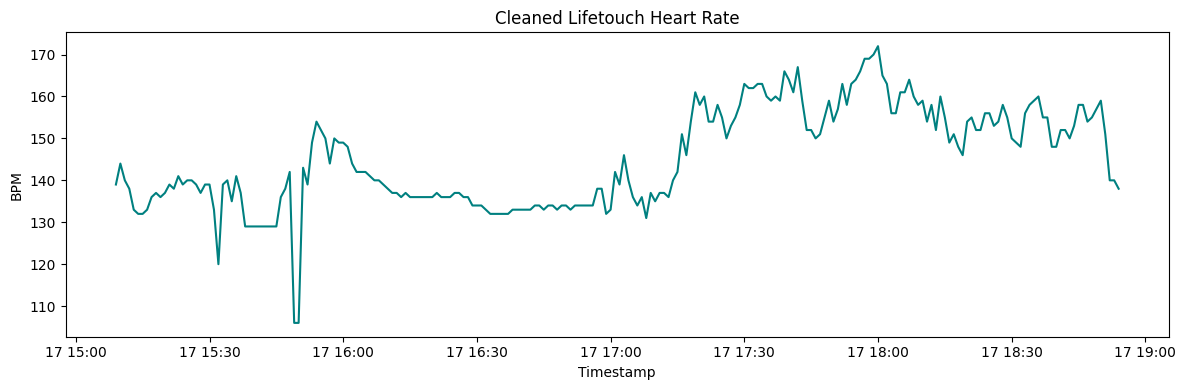

In [3]:
heart_rate = df['Lifetouch Heart Rate']
heart_rate = heart_rate.where(heart_rate < 250).ffill()

print(f"Cleaned range: {heart_rate.min():.0f} -- {heart_rate.max():.0f} bpm")
print(f"Total observations: {len(heart_rate)}")

plt.figure(figsize=(12, 4))
plt.plot(heart_rate, color='teal', linewidth=1.5)
plt.title('Cleaned Lifetouch Heart Rate')
plt.ylabel('BPM')
plt.xlabel('Timestamp')
plt.tight_layout()
plt.savefig('ts_history_v2.png', dpi=150)
plt.show()

## 3 -- Stationarity Check

In [4]:
adf_result = adfuller(heart_rate.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value:       {adf_result[1]:.4f}")

ADF Statistic: -2.0063
p-value:       0.2838


The ADF p-value suggests the series may not be strictly stationary after imputation, supporting the use of differencing ($d=1$) in our ARIMA-family models.

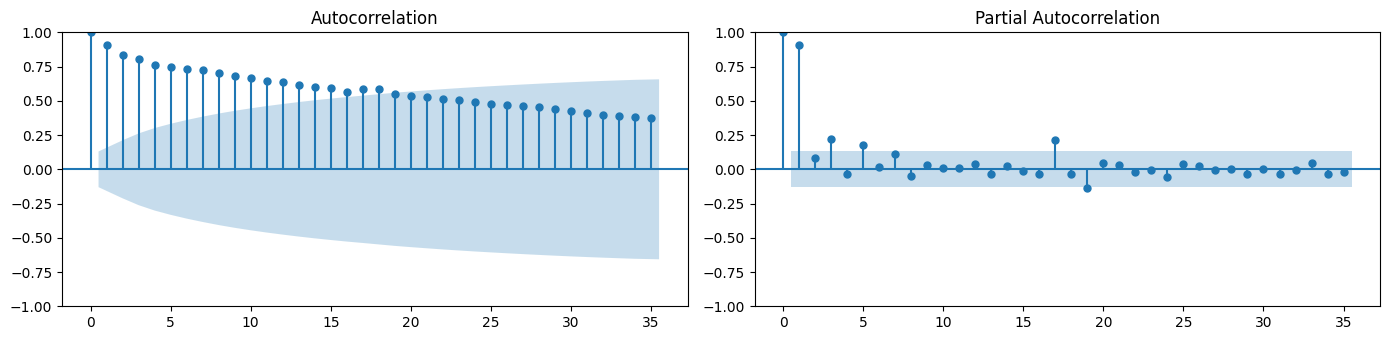

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3.5))
plot_acf(heart_rate.dropna(), ax=axes[0], lags=35)
plot_pacf(heart_rate.dropna(), ax=axes[1], lags=35)
plt.tight_layout()
plt.show()

## 4 -- Train / Validation Split
We hold out the final 20 observations, directly mirroring the 20-step prediction horizon required.

In [6]:
split_point = len(heart_rate) - 20
train, val = heart_rate.iloc[:split_point], heart_rate.iloc[split_point:]

print(f"Training: {len(train)} observations")
print(f"Validation: {len(val)} observations")

Training: 206 observations
Validation: 20 observations


## 5 -- Model Benchmarking
Three models are compared:
1. **ARIMA(1,1,1)** -- a parsimonious differenced model.
2. **SARIMA(1,1,1)(0,0,0,0)** -- extending ARIMA with a seasonal inspection (none expected, but worth verifying).
3. **Simple Exponential Smoothing (SES)** -- a level-only smoothing method with no trend assumption.

In [7]:
def score(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.3f}  |  MAE: {mae:.3f}  |  MAPE: {mape:.2f}%\n")
    return rmse, mae, mape

# ARIMA(1,1,1)
arima_fit = ARIMA(train, order=(1, 1, 1)).fit()
arima_fc = arima_fit.forecast(steps=len(val))
arima_rmse, arima_mae, arima_mape = score(val, arima_fc, "ARIMA(1,1,1)")

# SARIMA(1,1,1)(0,0,0,0)
sarima_fit = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit(disp=False)
sarima_fc = sarima_fit.forecast(steps=len(val))
sarima_rmse, sarima_mae, sarima_mape = score(val, sarima_fc, "SARIMA(1,1,1)(0,0,0,0)")

# Simple Exponential Smoothing
ses_fit = SimpleExpSmoothing(train, initialization_method='estimated').fit()
ses_fc = ses_fit.forecast(len(val))
ses_rmse, ses_mae, ses_mape = score(val, ses_fc, "Simple Exp. Smoothing")

--- ARIMA(1,1,1) ---
RMSE: 6.855  |  MAE: 4.861  |  MAPE: 3.32%

--- SARIMA(1,1,1)(0,0,0,0) ---
RMSE: 6.855  |  MAE: 4.861  |  MAPE: 3.32%

--- Simple Exp. Smoothing ---
RMSE: 7.938  |  MAE: 5.734  |  MAPE: 3.93%



### Validation Forecast Plot

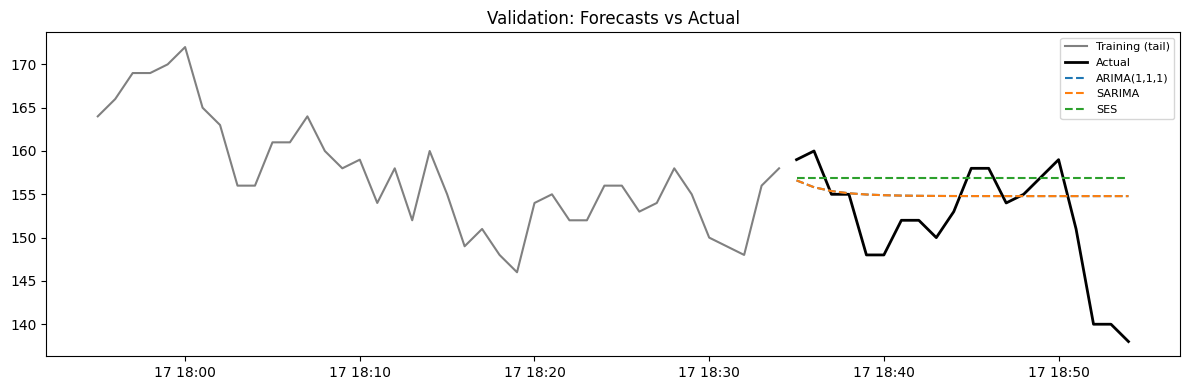

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(train.index[-40:], train.iloc[-40:], label='Training (tail)', color='grey')
plt.plot(val.index, val, label='Actual', color='black', linewidth=2)
plt.plot(val.index, arima_fc, label='ARIMA(1,1,1)', linestyle='--')
plt.plot(val.index, sarima_fc, label='SARIMA', linestyle='--')
plt.plot(val.index, ses_fc, label='SES', linestyle='--')
plt.title('Validation: Forecasts vs Actual')
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('ts_forecast_v2.png', dpi=150)
plt.show()

In [9]:
scoreboard = {
    'ARIMA(1,1,1)':  (arima_rmse, arima_mae, arima_mape),
    'SARIMA':        (sarima_rmse, sarima_mae, sarima_mape),
    'SES':           (ses_rmse, ses_mae, ses_mape),
}
best_name = min(scoreboard, key=lambda k: scoreboard[k][0])
print(f"Best model (lowest RMSE): {best_name}")

Best model (lowest RMSE): ARIMA(1,1,1)


## 6 -- Final 20-Step Forecast
The winning model is retrained on the full cleaned series and used to generate the submission predictions.

In [10]:
print(f"Retraining {best_name} on all {len(heart_rate)} observations...")

if best_name == 'ARIMA(1,1,1)':
    final = ARIMA(heart_rate, order=(1, 1, 1)).fit()
    forecast_20 = final.forecast(steps=20)
elif best_name == 'SARIMA':
    final = SARIMAX(heart_rate, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0)).fit(disp=False)
    forecast_20 = final.forecast(steps=20)
else:
    final = SimpleExpSmoothing(heart_rate, initialization_method='estimated').fit()
    forecast_20 = final.forecast(20)

out = pd.DataFrame({
    'Observation (Future Minute)': range(1, 21),
    'Predicted_Heart_Rate': np.round(forecast_20.values, 2)
})
out.to_csv('test-predictions_v2.csv', index=False)
print("Predictions saved to test-predictions_v2.csv")
out

Retraining ARIMA(1,1,1) on all 226 observations...


Predictions saved to test-predictions_v2.csv


,Observation (Future Minute),Predicted_Heart_Rate
0,1,141.10
1,2,143.01
2,3,144.19
3,4,144.91
4,5,145.35
5,6,145.63
6,7,145.79
7,8,145.90
8,9,145.96
9,10,146.00
